In [605]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

#!pip install --upgrade sklearn
#!pip install --upgrade scikit-learn

In [606]:
df = pd.read_csv('raw_data/KaggleV2-May-2016.csv')

In [607]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [801]:
#check in every appointment id is unique
len(df.AppointmentID.value_counts()) == len(df)

True

In [608]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [609]:
#convert dates to datetime format getting rid of the hour

from datetime import datetime

df.ScheduledDay = pd.to_datetime(df.ScheduledDay)
df.ScheduledDay = df.ScheduledDay.apply(lambda x: x.floor('D'))
df.AppointmentDay = pd.to_datetime(df.AppointmentDay)
df.AppointmentDay = df.AppointmentDay.apply(lambda x: x.floor('D'))

In [610]:
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No


In [611]:
#convert gender to numerical values
df['Gender'] = df['Gender'].replace('F', 0)
df['Gender'] = df['Gender'].replace('M', 1)

In [612]:
#check if the conversion went right
df['Gender'].unique()

array([0, 1])

In [613]:
df['No-show'] = df['No-show'].replace('Yes', 1)
df['No-show'] = df['No-show'].replace('No', 0)

In [614]:
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,5.589978e+14,5642503,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0
2,4.262962e+12,5642549,0,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0


In [615]:
# X = df[['Gender', 'Age', 'Scholarship', 
        # 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']]

# y = df['No-show']

In [616]:
#visualize distribution for different feature values
# for column in X.columns:
    # plt.hist(df[column])
    # plt.xlabel(column)
    # plt.show()

In [617]:
#create column containing how many number of days in advance the applointment was scheduled
df['days_in_advance'] =  df.AppointmentDay - df.ScheduledDay
df['days_in_advance'] = df['days_in_advance'].apply(lambda x: x.days)

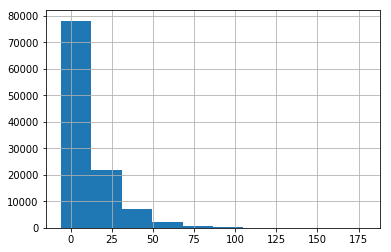

In [618]:
df['days_in_advance'].hist();

In [619]:
len(df)

110527

In [620]:
#check where the values for days_in_advance are negative: drop these rows
df = df.drop(df[df['days_in_advance'] < 0].index)

In [621]:
df = df.reset_index(drop=True)

In [622]:
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,days_in_advance
0,2.987250e+13,5642903,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0
1,5.589978e+14,5642503,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0
2,4.262962e+12,5642549,0,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,0


In [623]:
#check if it worked: YES
#df['days_in_advance'] < 0

In [624]:
#create column with month of the appointment


df['appointment_month'] =  df.AppointmentDay.apply(lambda x: x.month)

In [625]:
df['appointment_month'].unique()

array([4, 5, 6])

In [626]:
#create column with day of the week of the appointment

df['appointment_day_of_the_week'] =  df.AppointmentDay.apply(lambda x: x.weekday())

In [627]:
df['appointment_day_of_the_week'].unique()

array([4, 1, 0, 2, 3, 5])

In [628]:
len(df)

110522

## One hot encoding

In [629]:
#create binary values for appointment_month

In [630]:
from sklearn.preprocessing import OneHotEncoder

In [631]:
month_category = df["appointment_month"].values.reshape(-1, 1)

In [632]:
len(month_category)
#df["appointment_day_of_the_week"]

110522

In [633]:
encoder = OneHotEncoder(drop='first', categories='auto').fit(month_category)

In [634]:
len(df)

110522

In [635]:
encoder.categories_

[array([4, 5, 6])]

In [636]:
len(df)

110522

In [637]:
encoder.get_feature_names(["month_appointment"])

array(['month_appointment_5', 'month_appointment_6'], dtype=object)

In [638]:
len(df)

110522

In [639]:
ohe = pd.DataFrame(encoder.transform(month_category).toarray(),
                   columns=encoder.get_feature_names(["month_appointment"]))

In [640]:
ohe.columns

Index(['month_appointment_5', 'month_appointment_6'], dtype='object')

In [641]:
df.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,days_in_advance,appointment_month,appointment_day_of_the_week
110517,2.572134e+12,5651768,0,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,0,35,6,1
110518,3.596266e+12,5650093,0,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,0,35,6,1
110519,1.557663e+13,5630692,0,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,0,41,6,1
110520,9.213493e+13,5630323,0,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,0,41,6,1
110521,3.775115e+14,5629448,0,2016-04-27,2016-06-07,54,MARIA ORTIZ,0,0,0,0,0,1,0,41,6,1


In [642]:
df = df.drop(["appointment_month"], axis=1)

In [643]:
df.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,days_in_advance,appointment_day_of_the_week
110517,2.572134e+12,5651768,0,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,0,35,1
110518,3.596266e+12,5650093,0,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,0,35,1
110519,1.557663e+13,5630692,0,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,0,41,1
110520,9.213493e+13,5630323,0,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,0,41,1
110521,3.775115e+14,5629448,0,2016-04-27,2016-06-07,54,MARIA ORTIZ,0,0,0,0,0,1,0,41,1


In [644]:
df = pd.concat([df, ohe], axis=1, join='inner')

In [645]:
len(df)

110522

In [646]:
df.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,days_in_advance,appointment_day_of_the_week,month_appointment_5,month_appointment_6
110517,2.572134e+12,5651768,0,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,0,35,1,0.0,1.0
110518,3.596266e+12,5650093,0,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,0,35,1,0.0,1.0
110519,1.557663e+13,5630692,0,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,0,41,1,0.0,1.0
110520,9.213493e+13,5630323,0,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,0,41,1,0.0,1.0
110521,3.775115e+14,5629448,0,2016-04-27,2016-06-07,54,MARIA ORTIZ,0,0,0,0,0,1,0,41,1,0.0,1.0


In [647]:
#create categories for appointment_day_of_week

day_of_week_category = df["appointment_day_of_the_week"].values.reshape(-1, 1)

In [648]:
df["appointment_day_of_the_week"].unique()

array([4, 1, 0, 2, 3, 5])

In [649]:

df.tail(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,days_in_advance,appointment_day_of_the_week,month_appointment_5,month_appointment_6
110512,5.574942e+12,5780122,0,2016-06-07,2016-06-07,19,MARIA ORTIZ,0,0,0,0,0,0,0,0,1,0.0,1.0
110513,7.263315e+13,5630375,0,2016-04-27,2016-06-07,50,MARIA ORTIZ,0,0,0,0,0,1,0,41,1,0.0,1.0
110514,6.542388e+13,5630447,0,2016-04-27,2016-06-07,22,MARIA ORTIZ,0,0,0,0,0,1,0,41,1,0.0,1.0
110515,9.969977e+14,5650534,0,2016-05-03,2016-06-07,42,MARIA ORTIZ,0,0,0,0,0,1,0,35,1,0.0,1.0
110516,3.635534e+13,5651072,0,2016-05-03,2016-06-07,53,MARIA ORTIZ,0,0,0,0,0,1,0,35,1,0.0,1.0
110517,2.572134e+12,5651768,0,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,0,35,1,0.0,1.0
110518,3.596266e+12,5650093,0,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,0,35,1,0.0,1.0
110519,1.557663e+13,5630692,0,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,0,41,1,0.0,1.0
110520,9.213493e+13,5630323,0,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,0,41,1,0.0,1.0
110521,3.775115e+14,5629448,0,2016-04-27,2016-06-07,54,MARIA ORTIZ,0,0,0,0,0,1,0,41,1,0.0,1.0


In [650]:
encoder = OneHotEncoder(drop='first', categories='auto').fit(day_of_week_category)

In [651]:
encoder.categories_

[array([0, 1, 2, 3, 4, 5])]

In [652]:
encoder.get_feature_names(["day_of_week_appointment"])

array(['day_of_week_appointment_1', 'day_of_week_appointment_2',
       'day_of_week_appointment_3', 'day_of_week_appointment_4',
       'day_of_week_appointment_5'], dtype=object)

In [653]:
ohe = pd.DataFrame(encoder.transform(day_of_week_category).toarray(),
                   columns=encoder.get_feature_names(["day_of_week_appointment"]))

In [654]:
df = pd.concat([df.drop("appointment_day_of_the_week", axis=1), ohe], axis=1, join='inner')

In [655]:
df.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,SMS_received,No-show,days_in_advance,month_appointment_5,month_appointment_6,day_of_week_appointment_1,day_of_week_appointment_2,day_of_week_appointment_3,day_of_week_appointment_4,day_of_week_appointment_5
110517,2.572134e+12,5651768,0,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,...,1,0,35,0.0,1.0,1.0,0.0,0.0,0.0,0.0
110518,3.596266e+12,5650093,0,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,...,1,0,35,0.0,1.0,1.0,0.0,0.0,0.0,0.0
110519,1.557663e+13,5630692,0,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,...,1,0,41,0.0,1.0,1.0,0.0,0.0,0.0,0.0
110520,9.213493e+13,5630323,0,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,...,1,0,41,0.0,1.0,1.0,0.0,0.0,0.0,0.0
110521,3.775115e+14,5629448,0,2016-04-27,2016-06-07,54,MARIA ORTIZ,0,0,0,...,1,0,41,0.0,1.0,1.0,0.0,0.0,0.0,0.0


## Create 2 more features: number of previous appointments, number of previous no-shows

In [779]:
def get_num_apptmnts_noshows(patient_id, df):
    '''Returns a list of dictionaries with numbers of previous apointments and number
    of previous no-shows for each appintment id'''
    
    df_subset = df[df['PatientId'] == patient_id]
    df_subset = df_subset.sort_values(by='AppointmentDay')
    df_subset = df_subset.reset_index()
    df_subset['number_of_previous_apptms'] = df_subset.index
    
    no_shows = []
    for i in df_subset.index:
        if i == 0:
            no_shows.append(0)
        else:
            df_slice = df_subset.iloc[0:i, :]
            no_shows.append(sum(df_slice['No-show']))
            
    df_subset['number_of_previous_noshows'] = no_shows
    
    subset_dict = df_subset[['AppointmentID', 'number_of_previous_apptms', 'number_of_previous_noshows']].to_dict(orient='index')
        
    return subset_dict



In [781]:
#apply function to the dataframe

In [ ]:
patient_ids = np.unique(df['PatientId'].values)

In [793]:
len(patient_ids)

62299

In [794]:
dict_values = []
for pid in patient_ids:
    dict_values.append(get_num_apptmnts_noshows(pid, df))

In [795]:
len(dict_values)

62299

In [802]:
test = dict_values[444][0]


In [803]:
test

{'AppointmentID': 5749222,
 'number_of_previous_apptms': 0,
 'number_of_previous_noshows': 0}

In [818]:
df['number_of_previous_apptms'] = np.nan
df['number_of_previous_noshows'] = np.nan

In [819]:
selected_row = df[df['AppointmentID'] == test['AppointmentID']]
index = selected_row.index
df.loc[index, 'number_of_previous_apptms'] = test['number_of_previous_apptms']
df.loc[index, 'number_of_previous_noshows'] = test['number_of_previous_noshows']

In [820]:
df.loc[index, :]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,days_in_advance,month_appointment_5,month_appointment_6,day_of_week_appointment_1,day_of_week_appointment_2,day_of_week_appointment_3,day_of_week_appointment_4,day_of_week_appointment_5,number_of_previous_apptms,number_of_previous_noshows
87594,7.187740e+09,5749222,0,2016-05-31,2016-06-02,5,JABOUR,1,0,0,...,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [821]:
#update the dataframe
for d in dict_values:
    for v in d.values():
        #v['AppointmentID']
        #v['number_of_previous_apptms']
        #v['number_of_previous_noshows']
        
        selected_row = df[df['AppointmentID'] == v['AppointmentID']]
        index = selected_row.index
        df.loc[index, 'number_of_previous_apptms'] = v['number_of_previous_apptms']
        df.loc[index, 'number_of_previous_noshows'] = v['number_of_previous_noshows']

In [822]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,days_in_advance,month_appointment_5,month_appointment_6,day_of_week_appointment_1,day_of_week_appointment_2,day_of_week_appointment_3,day_of_week_appointment_4,day_of_week_appointment_5,number_of_previous_apptms,number_of_previous_noshows
0,2.987250e+13,5642903,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,5.589978e+14,5642503,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,4.262962e+12,5642549,0,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,8.679512e+11,5642828,0,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,8.841186e+12,5642494,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
def update_dataframe(df):
    '''Updates dataframe with values for columns number_of_previous_apptms, number_of_previous_noshows'''
    
    patient_ids = np.unique(df['PatientId'].values)
    
    dict_values = []
    
    for pid in patient_ids:
        dict_values.append(get_num_apptmnts_noshows(pid, df))
    
    #update the dataframe
    for d in dict_values:
        for v in d.values():
        #v['AppointmentID']
        #v['number_of_previous_apptms']
        #v['number_of_previous_noshows']
            selected_row = df[df['AppointmentID'] == v['AppointmentID']]
            index = selected_row.index
            df.loc[index, 'number_of_previous_apptms'] = v['number_of_previous_apptms']
            df.loc[index, 'number_of_previous_noshows'] = v['number_of_previous_noshows']